In [1]:
##Ruohan Wang
##260911138
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from matplotlib.pyplot import gcf
random.seed(0)
np.random.seed(0)

In [3]:
K = 5
alpha = 1
beta = 0.001
iteration = 100

## Q1(Model)

In [63]:
class LDA(object):
    def __init__(self, docs, num_topics, alpha, beta, iteration):
        self.iteration = iteration
        self.D = docs.shape[0]
        self.M = docs.shape[1] 
        self.K = num_topics 
        
        self.alpha = np.ones(self.K)
        self.beta = beta
        
        self.documents = {}
        for i, doc in enumerate(docs):
            tmp = []
            for j, word_freq in enumerate(doc):
                if(word_freq==0):
                    continue
                while(word_freq!=0):
                    tmp.append(j)
                    word_freq -=1
            self.documents[i] = tmp
            random.shuffle(self.documents[i])
        
        self.topic_assignment = {} 
        ## n_wk.T
        self.topic_word_count = np.zeros([self.K, self.M])
        ##n_dk
        self.document_topic_count = np.zeros([self.D, self.K]) 
        ##n_k
        self.topic_count = np.zeros(self.K)
        ##words per document
        self.num_document = np.zeros(self.D)
        
        self.phi = np.zeros([self.K, self.M])
        self.theta = np.zeros([self.D, self.K])
        
    def Gibbs_sampling(self): 
        print("# of DOCS:", self.D)                            
        print("# of TOPICS:", self.K)
        print("# of VOCABS:", self.M)
        ## initialization
        for doc_idx, doc in enumerate(self.documents):
            random_topics = np.random.randint(0, self.K-1, size=len(self.documents[doc]))
            self.topic_assignment[doc_idx] = random_topics
            for word_idx, word in enumerate(self.documents[doc]):
                random_topic = random_topics[word_idx]
                self.topic_word_count[random_topic, word] += 1
                self.document_topic_count[doc_idx, random_topic] += 1 
                self.topic_count[random_topic] += 1
                self.num_document[doc_idx] += 1
        print("Finish Initialization.")
        
        ## Collapsed Gibbs Sampling
        for i in range(self.iteration):
            for doc_idx, doc in enumerate(self.documents):
                for word_idx, word in enumerate(self.documents[doc]):
                    z = self.topic_assignment[doc_idx][word_idx]              
                    self.topic_word_count[z,word] -= 1
                    self.document_topic_count[doc_idx, z] -= 1
                    self.topic_count[z] -= 1
                    self.num_document[doc_idx] -= 1
                    
                    p_z = (self.alpha + self.document_topic_count[doc_idx]) / \
                    (np.sum(self.alpha) + self.num_document[doc_idx]) * \
                    ((self.beta + self.topic_word_count[:, word]) \
                    / (self.beta * self.M + self.topic_count))
                    new_z = np.random.multinomial(1, p_z / np.sum(p_z)).argmax()
                    
                    self.topic_assignment[doc_idx][word_idx] = new_z
                    self.topic_word_count[new_z,word] += 1
                    self.document_topic_count[doc_idx, new_z] += 1
                    self.topic_count[new_z] += 1
                    self.num_document[doc_idx]+= 1
            
            ## normalization phi and theta
            for k in range(self.K):
                for w in range(self.M):
                    self.phi[k][w] = (self.beta + self.topic_word_count[k][w] ) / (self.beta * self.M + self.topic_count[k])
            for d in range(self.D):
                for k in range(self.K):
                    self.theta[d][k] = (self.document_topic_count[d][k] + self.alpha[k])/(self.num_document[d] + np.sum(self.alpha))
        print("Finish Training.")

In [71]:
## Data Pre-processing

##Meta data
ICD_meta = pd.read_csv("D_ICD_DIAGNOSES.csv.gz", header=0)
ICD_meta = ICD_meta[['ICD9_CODE','SHORT_TITLE']]
ICD_meta['ICD9_CODE'] = ICD_meta['ICD9_CODE'].str.lstrip('0')
ICD_meta['Compound_ID'] = ICD_meta['ICD9_CODE'] + "-" + ICD_meta['SHORT_TITLE']

##Documents
DIAGNOSES_ICD = pd.read_csv("MIMIC3_DIAGNOSES_ICD_subset.csv.gz")
patient_list = DIAGNOSES_ICD.SUBJECT_ID.unique().tolist()
D = len(patient_list)
patient_idx_meta = {k: v for v, k in enumerate(patient_list)}
ICD_list = DIAGNOSES_ICD.ICD9_CODE.unique().tolist()
M = len(ICD_list)
vocab_idx_meta = {k: v for v, k in enumerate(ICD_list)}
idx_vocab_meta = {v: k for v, k in enumerate(ICD_list)}

docs = np.zeros([D, M])
for index, row in DIAGNOSES_ICD.iterrows():
    patient_idx = patient_idx_meta[row['SUBJECT_ID']]
    ICD_idx = vocab_idx_meta[row['ICD9_CODE']]
    docs[patient_idx, ICD_idx] += 1

In [72]:
lda = LDA(docs, K, alpha, beta, iteration)
lda.Gibbs_sampling()

# of DOCS: 689
# of TOPICS: 5
# of VOCABS: 387
Finish Initialization.


## Q2

In [291]:
def select_top_ICD(prob, vocab, K, num_top_ICD = 10):
    sns.set(rc={'figure.figsize':(5,8)})
    top_ICD_topic = np.zeros((num_top_ICD * K, K))
    top_code_list = []
    sorted_idx = np.argsort(-prob, axis=0)
    for k in range(K):
        sorted_index_k = sorted_idx[:, k] 
        for idx, ICD in enumerate(sorted_index_k[:num_top_ICD]): 
            top_code_list.append(vocab[ICD]) 
            top_ICD_topic[idx + k * num_top_ICD] = ICD_topic_prob[ICD]
    top_ICD_topic /= np.sum(top_ICD_topic, axis=0)
    sns.set(font_scale=0.8)
    sns.heatmap(top_ICD_topic, 
                cmap='OrRd', 
                vmin=0,
                vmax=0.15,
                xticklabels= ['Topic 1','Topic 2','Topic 3',
                              'Topic 4','Topic 5'],
                yticklabels=top_code_list, 
                linewidths=.1)
    plt.savefig('lda_result.png', dpi=200, bbox_inches='tight')
    plt.show()

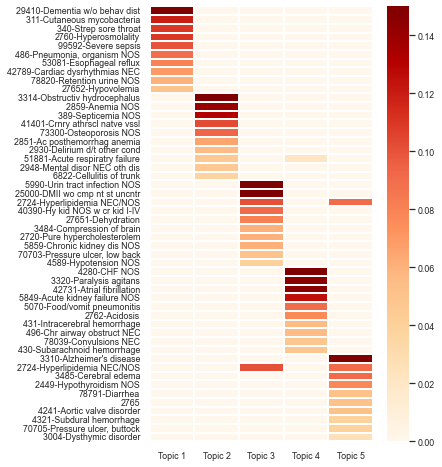

In [292]:
ICD_topic_prob = lda.phi.T
ICD_list = list(range(ICD_topic_prob.shape[0]))
ICD_code_list = [idx_vocab_meta[key] for key in ICD_list]
vocab = []
for key in ICD_code_list:
    value = ICD_meta[ICD_meta['ICD9_CODE'] == str(key)]['Compound_ID'].tolist()
    if value == []:
        value = [str(key)] 
    vocab.append(value[0])
select_top_ICD(lda.phi.T, vocab, K)

## Q3

In [278]:
target_ICD_idx = {}
for target_icd in ['331','332','340']:
    target_ICD_idx[target_icd] = []
for icd in vocab_idx_meta:
    if str(icd)[:3] == '331':
        target_ICD_idx['331'].append(vocab_idx_meta[icd])
    elif str(icd)[:3] == '332':
        target_ICD_idx['332'].append(vocab_idx_meta[icd])
    elif str(icd)[:3] == '340':
        target_ICD_idx['340'].append(vocab_idx_meta[icd])
patient_target = np.zeros([docs.shape[0], 3])
for doc_idx, doc in enumerate(docs):
    for target_idx, target_icd in enumerate(target_ICD_idx):
        for i in target_ICD_idx[target_icd]:
            if doc[i] == 1:
                patient_target[doc_idx][target_idx] = 1

In [279]:
corr_matrix = np.zeros([K, len(target_ICD_idx)])
for topic in range(K):
    for word in range(len(target_ICD_idx)):
        corr, _ = stats.pearsonr(lda.theta.T[topic], patient_target.T[word])
        corr_matrix[topic][word] = corr

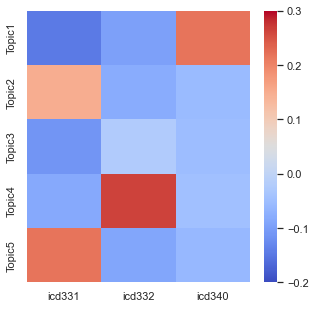

In [280]:
sns.set(rc={'figure.figsize':(5,5)})
sns.heatmap(corr_matrix,
            cmap='coolwarm', 
            vmin=-0.2,
            vmax=0.3,
            yticklabels= ['Topic1','Topic2','Topic3',
                              'Topic4','Topic5'],
            xticklabels =  ['icd331','icd332','icd340'])
plt.savefig('corr_result.png', dpi=200)
plt.show()

## Q4

In [293]:
def select_top_patient(prob, K, num_top_patient = 100):
    top_patient_topic = np.zeros((num_top_patient * K, K))
    icd331_list = []
    icd332_list = []
    icd340_list = []
    sorted_idx = np.argsort(-lda.theta, axis=0)
    for k in range(K):
        sorted_index_k = sorted_idx[:, k] 
        for idx, pat in enumerate(sorted_index_k[:num_top_patient]):
            top_patient_topic[idx + k * num_top_patient] = prob[pat]
            icd331_list.append(patient_target[pat][0])
            icd332_list.append(patient_target[pat][1])
            icd340_list.append(patient_target[pat][2])

    icd331_seed_name = ['icd331 False', 'icd331 True']
    icd331_seed_labels = []
    icd331_index_labels = []

    icd332_seed_name = ['icd332 False', 'icd332 True']
    icd332_seed_labels = []
    icd332_index_labels = []

    icd340_seed_name = ['icd340 False', 'icd340 True']
    icd340_seed_labels = []
    icd340_index_labels = []

    for s in icd331_list:
        if s == 1:
            icd331_seed_labels.append(icd331_seed_name[0])
            icd331_index_labels.append(1)
        elif s == 0:
            icd331_seed_labels.append(icd331_seed_name[1])
            icd331_index_labels.append(0)

    for s in icd332_list:
        if s == 1:
            icd332_seed_labels.append(icd332_seed_name[0])
            icd332_index_labels.append(1)
        elif s == 0:
            icd332_seed_labels.append(icd332_seed_name[1])
            icd332_index_labels.append(0)

    for s in icd340_list:
        if s == 1:
            icd340_seed_labels.append(icd340_seed_name[0])
            icd340_index_labels.append(1)
        elif s == 0:
            icd340_seed_labels.append(icd340_seed_name[1])
            icd340_index_labels.append(0)

    seed_class_label = np.arange(len(icd331_seed_name))
    
    net_pal = sns.cubehelix_palette(len(seed_class_label), light=1, dark=0, start=1.0, rot=-2)
    class_lut1 = dict(zip(seed_class_label, net_pal))
    class_colors1 = list(map(class_lut1.get, icd331_index_labels))

    net_pal2 = sns.cubehelix_palette(len(seed_class_label), light=1, dark=0.7, start=1.0, rot=-2)
    class_lut2 = dict(zip(seed_class_label , net_pal2))
    class_colors2 = list(map(class_lut2.get, icd332_index_labels))

    net_pal3 = sns.cubehelix_palette(len(seed_class_label), light=1, dark=0.5, start=0.6, rot=-2)
    class_lut3 = dict(zip(seed_class_label , net_pal3))
    class_colors3 = list(map(class_lut3.get, icd340_index_labels))

    g = sns.clustermap(top_patient_topic, 
                       row_cluster=False, 
                       col_cluster=False,
                       dendrogram_ratio=(0.6,0.1),
                       cbar_pos=(1, 0.25, 0.05, 0.08),
                       row_colors=[class_colors1, class_colors2, class_colors3], 
                       cmap='OrRd',
                       xticklabels=['Topic 1','Topic 2','Topic 3',
                                  'Topic 4','Topic 5'], 
                       yticklabels=False, 
                       figsize=(10,10))

    for label in seed_class_label:
        g.ax_col_dendrogram.bar(0, 0, color=class_lut1[label], 
                                label=icd331_seed_name[label], linewidth=0);
    l1 = g.ax_col_dendrogram.legend(ncol=1, bbox_to_anchor=(1.13, .5), bbox_transform=gcf().transFigure, facecolor='white', framealpha=1, fontsize='10')
    for label in seed_class_label:
        g.ax_col_dendrogram.bar(0, 0, color=class_lut2[label], 
                                label=icd332_seed_name[label], linewidth=0);
    l2 = g.ax_col_dendrogram.legend(ncol=1, bbox_to_anchor=(1.13, .5), bbox_transform=gcf().transFigure, facecolor='white', framealpha=1, fontsize='10')
    for label in seed_class_label:
        g.ax_col_dendrogram.bar(0, 0, color=class_lut3[label], 
                                label=icd340_seed_name[label], linewidth=0);
    l3 = g.ax_col_dendrogram.legend(ncol=1, bbox_to_anchor=(1.13,.5), bbox_transform=gcf().transFigure, facecolor='white', framealpha=1, fontsize='10')    

    sns.set_style(style="darkgrid") 
    plt.savefig('patient_topic_mixture_result.png', dpi=200, bbox_inches='tight')
    plt.show()

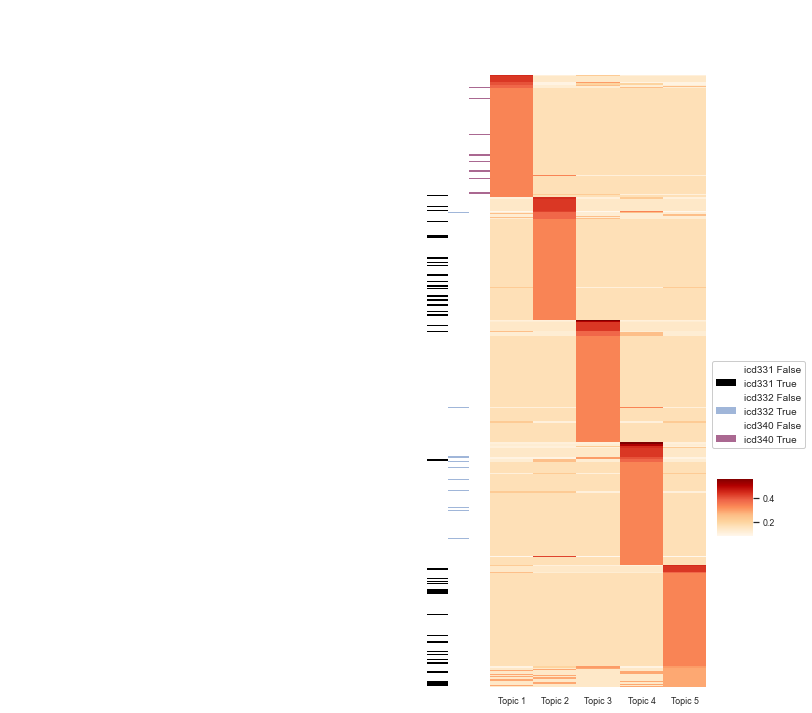

In [294]:
select_top_patient(lda.theta,K)